In [2]:
# To add a new cell, type '# %%'
# To add a new markdown cell, type '# %% [markdown]'
# %%
from cnn_utils import *
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.engine import  Model
from keras.layers import Flatten, Dense, Input, GlobalAveragePooling2D
from keras.optimizers import Adam


## Verify the installation of Keras VGGFace


In [3]:
# import sys
# print(sys.executable)


In [4]:
# check version of keras_vggface
# import keras_vggface
# print version
# print(keras_vggface.__version__)

## Data Preprocessing

In [5]:
df = create_dataframe('/../raw_data/dataset_062920.json')
df.head()

,eyeImage,leftEye,rightEye,y
0,"[[[0.49019607843137253, 0.4627450980392157, 0....","[-0.06916704732662149, 0.19730078279591035, -0...","[0.17425771877389162, 0.21639015714266296, 0.2...","[-0.30000000000000004, -0.3019517795637199]"
1,"[[[0.19607843137254902, 0.1607843137254902, 0....","[-0.17658285534307594, 0.18033866676032262, -0...","[0.06629549190581052, 0.1988126179958256, 0.10...","[0.30000000000000004, -0.9012629161882894]"
2,"[[[0.2196078431372549, 0.19215686274509805, 0....","[-0.17382043840055927, 0.17981051564675177, -0...","[0.06089991895895852, 0.18628686237123016, 0.0...","[0.8999999999999999, -0.9012629161882894]"
3,"[[[0.2196078431372549, 0.17647058823529413, 0....","[-0.15968611544730582, 0.18524077990937093, -0...","[0.08123800929222913, 0.1904861112443328, 0.11...","[-0.30000000000000004, 0.8989667049368542]"
4,"[[[0.5882352941176471, 0.5647058823529412, 0.6...","[-0.07825260742468576, 0.16963032408957468, -0...","[0.1666792245722788, 0.19617187288354976, 0.20...","[-0.30000000000000004, 0.2996555683122848]"


In [6]:
len(df)

846

### Try to use Quaternary encoding to see if we have mislabelled data

In [11]:
# import pandas as pd
# d = {'col1': [i for i in range(20)], 'col2': [j for j in range(20,40)]}
# df = pd.DataFrame(data=d)
# df
# train = df.sample(frac=0.7).sort_index()
# validation = df.drop(train.index).sort_index()
# train

,col1,col2
0,0,20
1,1,21
3,3,23
5,5,25
7,7,27
8,8,28
9,9,29
10,10,30
11,11,31
12,12,32


In [14]:
# randomly select training examples
x_train, x_validation, y_train, y_validation = create_train_validation(df)

# generate binary y labels
# y_train_binary = create_binary_labels(y_train)
# y_validation_binary = create_binary_labels(y_validation) # generate binary y labels

# generate quaternary y labels
y_train_quaternary = create_quaternary_labels(y_train)
y_validation_quaternary = create_quaternary_labels(y_validation) # generate binary y labels


NameError: name 'create_train_validation' is not defined

In [9]:
# visualize some data
# plot_eyeImages(x_train,y_train_binary)

In [10]:
# prepare data for feeding in CNN
eyeImage_train, leftEye_train, rightEye_train, quaternary_train = create_tf_data(x_train, y_train_quaternary)
eyeImage_test, leftEye_test, rightEye_test, quaternary_test = create_tf_data(x_validation, y_validation_quaternary)


# encoding the data
# binary_encoder = LabelEncoder()
# binary_encoder.fit(binary_train)
# binary_train = binary_encoder.transform(binary_train)
# binary_test = binary_encoder.transform(binary_test)

# # one-hot encoding the data
# binary_train = to_categorical(binary_train)
# binary_test = to_categorical(binary_test)


In [14]:
quaternary_train

array([[0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.]], dtype=float32)

In [17]:
quaternary_encoder = LabelEncoder()
quaternary_encoder.fit(quaternary_train)
quaternary_train = quaternary_encoder.transform(quaternary_train)
quaternary_test = quaternary_encoder.transform(quaternary_test)

# one-hot encoding the data
quaternary_train = tf.keras.utils.to_categorical(quaternary_train)
quaternary_test = tf.keras.utils.to_categorical(quaternary_test)


ValueError: y should be a 1d array, got an array of shape (677, 4) instead.

In [18]:
quaternary_train

array([[0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.]], dtype=float32)

## VGGFace2 Transfer Learning

In [19]:
baseModel = VGGFace(model='resnet50',input_shape=(224,224,3),include_top=False,weights='vggface', pooling=None)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.




In [20]:
baseModel.summary()

                 
__________________________________________________________________________________________________
conv4_1_1x1_reduce (Conv2D)     (None, 14, 14, 256)  131072      activation_22[0][0]              
__________________________________________________________________________________________________
conv4_1_1x1_reduce/bn (BatchNor (None, 14, 14, 256)  1024        conv4_1_1x1_reduce[0][0]         
__________________________________________________________________________________________________
activation_23 (Activation)      (None, 14, 14, 256)  0           conv4_1_1x1_reduce/bn[0][0]      
__________________________________________________________________________________________________
conv4_1_3x3 (Conv2D)            (None, 14, 14, 256)  589824      activation_23[0][0]              
__________________________________________________________________________________________________
conv4_1_3x3/bn (BatchNormalizat (None, 14, 14, 256)  1024        conv4_1_3x3[0][0]         

In [22]:
for layer in baseModel.layers:
    layer.trainable=False

In [23]:
headModel = baseModel.get_layer('avg_pool').output
headModel = Flatten(name='flatten')(headModel)
headModel = Dense(4, activation='softmax', name='classifier')(headModel)


In [24]:
model = Model(inputs=baseModel.input, outputs=headModel)
base_learning_rate = 0.0001
adam = Adam(learning_rate=base_learning_rate)
loss = tf.keras.losses.CategoricalCrossentropy(
    from_logits=False,
    label_smoothing=0,
    reduction="auto",
    name="categorical_crossentropy",
)

model.compile(optimizer=adam,metrics=['accuracy'],loss = loss)


In [25]:
model.summary()

uce[0][0]         
__________________________________________________________________________________________________
activation_23 (Activation)      (None, 14, 14, 256)  0           conv4_1_1x1_reduce/bn[0][0]      
__________________________________________________________________________________________________
conv4_1_3x3 (Conv2D)            (None, 14, 14, 256)  589824      activation_23[0][0]              
__________________________________________________________________________________________________
conv4_1_3x3/bn (BatchNormalizat (None, 14, 14, 256)  1024        conv4_1_3x3[0][0]                
__________________________________________________________________________________________________
activation_24 (Activation)      (None, 14, 14, 256)  0           conv4_1_3x3/bn[0][0]             
__________________________________________________________________________________________________
conv4_1_1x1_increase (Conv2D)   (None, 14, 14, 1024) 262144      activation_24[0][0]      

In [26]:
history_1= model.fit(
	x = eyeImage_train,
	y = quaternary_train,
    validation_split=0.2,
    batch_size=32,
	epochs=10)



Train on 541 samples, validate on 136 samples
Epoch 1/20
541/541 [==============================] - 59s 108ms/step - loss: 2.1096 - accuracy: 0.2421 - val_loss: 1.4842 - val_accuracy: 0.2353
Epoch 2/20
541/541 [==============================] - 51s 95ms/step - loss: 1.9317 - accuracy: 0.2773 - val_loss: 1.4788 - val_accuracy: 0.2353
Epoch 3/20
541/541 [==============================] - 50s 93ms/step - loss: 1.7981 - accuracy: 0.2884 - val_loss: 1.4790 - val_accuracy: 0.2353
Epoch 4/20
541/541 [==============================] - 53s 97ms/step - loss: 1.7154 - accuracy: 0.3087 - val_loss: 1.4753 - val_accuracy: 0.2353
Epoch 5/20
541/541 [==============================] - 53s 98ms/step - loss: 1.6541 - accuracy: 0.3567 - val_loss: 1.4773 - val_accuracy: 0.2353
Epoch 6/20
541/541 [==============================] - 50s 92ms/step - loss: 1.5403 - accuracy: 0.3641 - val_loss: 1.4737 - val_accuracy: 0.2353
Epoch 7/20
541/541 [==============================] - 52s 95ms/step - loss: 1.4790 - acc

KeyboardInterrupt: 

In [ ]:
# summarize history for accuracy
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('model accuracy of vggface2 2')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
fig1 = plt.gcf()
plt.show()
plt.draw()
fig1.savefig('results/vggface2_2_acc.png')

# summarize history for loss
plt.plot(history_1.history['loss'])
plt.plot(history_1.history['val_loss'])
plt.title('model loss of vggface2 2')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
fig1 = plt.gcf()
plt.show()
plt.draw()
fig1.savefig('results/vggface2_2_loss.png')


In [ ]:
history_2 = model.evaluate(eyeImage_test, quaternary_test)

## Updated version of `create_tf_data`, July 1, 2020
Substract every image from the average image, every landmarks from the average landmarks positions

### Get the mean image of the training dataset

In [21]:
mean_image = np.mean(eyeImage_train, axis = 0)
# meadian_image = np.median(eyeImage_train, axis = 0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


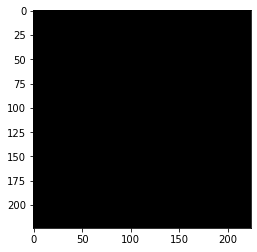

In [22]:
plt.imshow(mean_image)
# plt.savefig("results/average_img.png")

### Updated version of `create_tf_data`

In [23]:
def create_tf_data(X, Y):
    """
    take in the X and Y and transform each column into np array
    Every column in X will be substracted from its mean
    """
    
    eyeImage = np.stack(X['eyeImage'].to_numpy())
    image_mean = np.mean(eyeImage, axis=0)
    eyeImage = eyeImage-image_mean

    leftEye = np.stack(X['leftEye'].to_numpy())
    leftEye_mean = np.mean(leftEye, axis=0)
    leftEye = leftEye-leftEye_mean

    rightEye = np.stack(X['rightEye'].to_numpy())
    rightEye_mean = np.mean(rightEye, axis=0)
    rightEye = rightEye-rightEye_mean

    y = np.stack(Y['y'].to_numpy())
    return eyeImage, leftEye, rightEye, y

### Verify that we substract the mean correctly

In [24]:
_,left,_,_ = create_tf_data(x_train, y_train_binary)

NameError: name 'y_train_binary' is not defined

In [25]:
np.sum(left,axis=0)

NameError: name 'left' is not defined